In [6]:
import numpy as np
import pandas as pd
from functions import *
from schemes import *
from plot import * 
from Kepler import *
from adaptive import *

%matplotlib inline

In [3]:
def findStability(T, C, hlim, Elim, r0s, v0s, G, masses, h0 = 0.01, t0 = 0):
    
    # reposition centre of mass to origin with no momentum 
    rcom, vcom = CentreOfMass(r0s, v0s, masses)
    r0s -= rcom
    v0s -= vcom
    
    # Make a copy of initial values
    rs = np.copy(r0s)
    vs = np.copy(v0s)
    t = t0
    h = h0
    
    E_traj = [TotalEnergy(r0s, v0s, G, masses)]
    
    E0 = np.sum(E_traj[0])
    E0hat = E0 
    
    ## conditions to avoid dividing by zero 
    if E0hat == 0: E0hat = np.max(np.abs(E_traj[0])) 
    if E0hat == 0: E0hat = 1

    def maxDist(rs):
        d = -1
        n = len(rs)
        for i in range(0,n-1): 
            for j in range(i, n):
                d = max(d, np.linalg.norm(rs[i]-rs[j]))
        return d

    rs, vs = PEFRLStep(rs, vs, h, G, masses) 
    
    # run scheme for requried number of steps 
    while t <= T:
        h = C * findh(rs, vs) # proposed timestep

        rs_bar, vs_bar = PEFRLStep(rs, vs, h, G, masses)
        h_bar = C * findh(rs_bar, vs_bar) # proposed timestep

        h_new = (h + h_bar) / 2
        
        rs, vs = PEFRLStep(rs, vs, h_new, G, masses)

        E = TotalEnergy(rs, vs, G, masses) # Calculate Energy 
        relE = np.abs(np.sum(E) - E0) / np.abs(E0hat)

        if h_new < hlim: 
            reason = 2
            break 
        if t+h_new > T: 
            reason =  1
            break 
        if relE > Elim:
            reason = 3
            break 
        if maxDist(rs) > 10:
            reason = 0
            break 
        
        E_traj.append(relE)
        t += h_new
    
    return reason, t, np.max(np.array(relE))

In [4]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

R = 1

# position
r1 = np.array([-R,0.0,0.0], dtype="float64")
r2 = np.array([0,0.0,0.0], dtype="float64")
r3 = np.array([R,0.0,0.0], dtype="float64")

px = 0.347111
py = 0.532728

# velocity 
v1 = np.array([px,py,0], dtype="float64")
v2 = np.array([-2 * px,-2*py,0], dtype="float64")
v3 = np.array([px,py,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

In [5]:
T = 1000
hlim = 0.01
Elim = 0.01
C = 0.55

In [6]:
def findR(v0s, E0, masses):
    ke = np.sum(KineticEnergy(v0s, masses))
    R = 5 / (2 * (ke - E0))
    return R

In [7]:
exs = np.linspace(-0.3,0.3,200)
eys = np.flip(np.linspace(-0.3, 0.3, 200))

In [18]:
E0 = np.sum(TotalEnergy(r0s, v0s, G, masses))

stabilities = []
ts = []
Es = []
for ex in exs:
    for ey in eys:
        print(ex, ey)
        pxhat = px + ex
        pyhat = py + ey

        # velocity 
        v1hat = np.array([pxhat,pyhat,0], dtype="float64")
        v2hat = np.array([-2 * pxhat,-2*pyhat,0], dtype="float64")
        v3hat = np.array([pxhat,pyhat,0], dtype="float64")
        v0shat = np.array([v1hat,v2hat,v3hat])

        R = findR(v0shat, E0, masses)
        
        # position
        r1hat = np.array([-R,0.0,0.0], dtype="float64")
        r2hat = np.array([0,0.0,0.0], dtype="float64")
        r3hat = np.array([R,0.0,0.0], dtype="float64")
        r0shat = np.array([r1hat,r2hat,r3hat])
        
        # print(np.sum(TotalEnergy(r0shat, v0shat, G, masses)) - E0)

        if (ex == 0) and (ey == 0): print('R', R)

        stability, escapet, maxE = findStability(T, C, hlim, Elim, r0shat, v0shat, G, masses)

        stabilities.append(stability)
        ts.append(escapet)
        Es.append(maxE)

stabilities = np.array(stabilities).reshape(len(exs), len(eys))
Es = np.array(stabilities).reshape(len(exs), len(eys))
ts = np.array(ts).reshape(len(exs), len(eys))

-0.3 0.3
3
-0.3 0.23333333333333334
3
-0.3 0.16666666666666669
3
-0.3 0.10000000000000003
3
-0.3 0.033333333333333326
3
-0.3 -0.033333333333333326
3
-0.3 -0.09999999999999998
2
-0.3 -0.16666666666666666
3
-0.3 -0.23333333333333334
3
-0.3 -0.3
2
-0.23333333333333334 0.3
3
-0.23333333333333334 0.23333333333333334
3
-0.23333333333333334 0.16666666666666669
3
-0.23333333333333334 0.10000000000000003
2
-0.23333333333333334 0.033333333333333326
2
-0.23333333333333334 -0.033333333333333326
2
-0.23333333333333334 -0.09999999999999998
3
-0.23333333333333334 -0.16666666666666666
2
-0.23333333333333334 -0.23333333333333334
3
-0.23333333333333334 -0.3
2
-0.16666666666666666 0.3
3
-0.16666666666666666 0.23333333333333334
2
-0.16666666666666666 0.16666666666666669
2
-0.16666666666666666 0.10000000000000003
3
-0.16666666666666666 0.033333333333333326
3
-0.16666666666666666 -0.033333333333333326
3
-0.16666666666666666 -0.09999999999999998
3
-0.16666666666666666 -0.16666666666666666
3
-0.16666666666666

In [3]:
import pandas as pd 
# df = pd.DataFrame(stabilities)
# df.to_csv("Data/Fig8/Fig8_Stability_0.3x0.3.csv")

# df = pd.DataFrame(Es)
# df.to_csv("Data/Fig8/Fig8_Stability_0.3x0.3Energy.csv")

# df = pd.DataFrame(ts)
# df.to_csv("Data/Fig8/Fig8_Stability_0.3x0.3ts.csv")

In [4]:
stabilities = pd.read_csv("Data/Fig8/Fig8_Stability_0.3x0.3.csv")

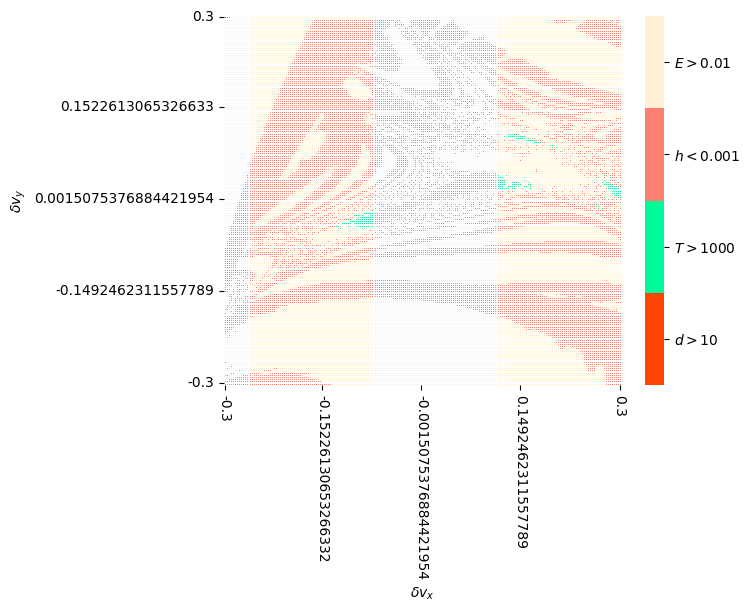

In [9]:
import seaborn as sns
from matplotlib.colors import ListedColormap


# Create a figure and axis for the heatmap
fig, ax = plt.subplots()

cmap = ListedColormap(['orangered','mediumspringgreen','salmon','papayawhip'])
# cmap = sns.color_palette('tab10', n_colors=4)

# Create the heatmap using Seaborn
sns.heatmap(stabilities.T,cmap = cmap,  cbar=True, ax=ax, vmin=0, vmax=3, linewidths = .5)

ax.set_xticks(np.arange(len(exs)))
ax.set_yticks(np.arange(len(eys)))
ax.set_xticklabels(exs, rotation = 270)
ax.set_yticklabels(eys, rotation = 0)

# Determine the tick positions
num_ticks = 5
tick_positions = np.linspace(0, stabilities.shape[0] - 1, num_ticks, dtype=int) 

# Set the tick positions and labels for both x-axis and y-axis
ax.set_xticks(tick_positions + 0.5)
ax.set_yticks(tick_positions + 0.5)
ax.set_xticklabels(exs[tick_positions])
ax.set_yticklabels(eys[tick_positions])

# Set axis labels and title
ax.set_xlabel(f'$\delta v_x$')
ax.set_ylabel('$\delta v_y$')

colorbar = ax.collections[0].colorbar
colorbar.set_ticks(0.375 * np.array([1, 3, 5, 7]))
colorbar.set_ticklabels(['$d > 10$', '$T > {1000}}$', '$h < 0.001$', '$E > 0.01$'])

# Show the plot
plt.show()
